# Predictive Modeling with heterogeneous data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore', DeprecationWarning)

<img src="files/images/predictive_modeling_data_flow.png">

## Loading tabular data from the Titanic kaggle challenge in a pandas Data Frame

Let us have a look at the Titanic dataset from the Kaggle Getting Started challenge at:

https://www.kaggle.com/c/titanic-gettingStarted

We can load the CSV file as a pandas data frame in one line:

In [2]:
#!curl -s https://dl.dropboxusercontent.com/u/5743203/data/titanic/titanic_train.csv | head -5
with open('titanic_train.csv', 'r') as f:
    for i, line in zip(range(5), f):
        print(line.strip())

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S


In [3]:
#data = pd.read_csv('https://dl.dropboxusercontent.com/u/5743203/data/titanic/titanic_train.csv')
data = pd.read_csv('titanic_train.csv')

pandas data frames have a HTML table representation in the IPython notebook. Let's have a look at the first 5 rows:

In [10]:
data.head(5); data.tail(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.75,NaN,Q


In [7]:
data.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

The data frame has 891 rows. Some passengers have missing information though: in particular Age and Cabin info can be missing. The meaning of the columns is explained on the challenge website:

https://www.kaggle.com/c/titanic-gettingStarted/data

A data frame can be converted into a numpy array by calling the `values` attribute:

In [14]:
list(data.columns)

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [ ]:
data.shape

In [15]:
data.values

array([[1, 0, 3, ..., 7.25, nan, 'S'],
       [2, 1, 1, ..., 71.2833, 'C85', 'C'],
       [3, 1, 3, ..., 7.925, nan, 'S'],
       ..., 
       [889, 0, 3, ..., 23.45, nan, 'S'],
       [890, 1, 1, ..., 30.0, 'C148', 'C'],
       [891, 0, 3, ..., 7.75, nan, 'Q']], dtype=object)

However this cannot be directly fed to a scikit-learn model:


- the target variable (survival) is mixed with the input data

- some attribute such as unique ids have no predictive values for the task

- the values are heterogeneous (string labels for categories, integers and floating point numbers)

- some attribute values are missing (nan: "not a number")

## Predicting survival

The goal of the challenge is to predict whether a passenger has survived from others known attribute. Let us have a look at the `Survived` columns:

In [ ]:
survived_column = data['Survived']
survived_column.dtype
survived_column

`data.Survived` is an instance of the pandas `Series` class with an integer dtype:

In [17]:
type(survived_column)

pandas.core.series.Series

The `data` object is an instance pandas `DataFrame` class:

In [23]:
type(data); print("Hello World");

Hello World


`Series` can be seen as homegeneous, 1D columns. `DataFrame` instances are heterogenous collections of columns with the same length.

The original data frame can be aggregated by counting rows for each possible value of the `Survived` column:

In [21]:
data.groupby('Survived').count()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
Survived,,,,,,,,,,,
0,549,549,549,549,424,549,549,549,549,68,549
1,342,342,342,342,290,342,342,342,342,136,340


In [ ]:
np.mean(survived_column == 0)

From this the subset of the full passengers list, about 2/3 perished in the event. So if we are to build a predictive model from this data, a baseline model to compare the performance to would be to always predict death. Such a constant model would reach around 62% predictive accuracy (which is higher than predicting at random):

pandas `Series` instances can be converted to regular 1D numpy arrays by using the `values` attribute:

In [24]:
target = survived_column.values

In [25]:
type(target)

numpy.ndarray

In [26]:
target.dtype

dtype('int64')

In [27]:
target[:5]

array([0, 1, 1, 1, 0], dtype=int64)

## Training a predictive model on numerical features

`sklearn` estimators all work with homegeneous numerical feature descriptors passed as a numpy array. Therefore passing the raw data frame will not work out of the box.

Let us start simple and build a first model that only uses readily available numerical features as input, namely `data['Fare']`, `data['Pclass']` and `data['Age']`.

In [28]:
numerical_features = data[['Fare', 'Pclass', 'Age']]
numerical_features.head(5)

,Fare,Pclass,Age
0,7.2500,3,22
1,71.2833,1,38
2,7.9250,3,26
3,53.1000,1,35
4,8.0500,3,35


Unfortunately some passengers do not have age information:

In [29]:
numerical_features.count()

Fare      891
Pclass    891
Age       714
dtype: int64

Let's use pandas `fillna` method to input the median age for those passengers:

In [30]:
median_features = numerical_features.dropna().median()
median_features

Fare      15.7417
Pclass     2.0000
Age       28.0000
dtype: float64

In [31]:
imputed_features = numerical_features.fillna(median_features)
imputed_features.count()

Fare      891
Pclass    891
Age       891
dtype: int64

In [33]:
imputed_features.head(5)
imputed_features.dropna().median()

Fare      14.4542
Pclass     3.0000
Age       28.0000
dtype: float64

Now that the data frame is clean, we can convert it into an homogeneous numpy array of floating point values:

In [34]:
features_array = imputed_features.values
features_array

array([[  7.25  ,   3.    ,  22.    ],
       [ 71.2833,   1.    ,  38.    ],
       [  7.925 ,   3.    ,  26.    ],
       ..., 
       [ 23.45  ,   3.    ,  28.    ],
       [ 30.    ,   1.    ,  26.    ],
       [  7.75  ,   3.    ,  32.    ]])

In [ ]:
features_array.dtype

Let's take the 80% of the data for training a first model and keep 20% for computing is generalization score:

In [35]:
from sklearn.cross_validation import train_test_split

features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.20, random_state=0)

In [44]:
print (features_train.shape)
print (features_test.shape)
print (target_train.shape)
print (target_test.shape)

(712, 3)
(179, 3)
(712,)
(179,)


In [49]:
target_train

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0,

Let's start with a simple model from sklearn, namely `LogisticRegression`:

In [51]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(C=1)
logreg.fit(features_train, target_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)

In [54]:
target_predicted = logreg.predict(features_test)

In [53]:
from sklearn.metrics import accuracy_score

accuracy_score(target_test, target_predicted)

0.73184357541899436

This first model has around 73% accuracy: this is better than our baseline that always predicts death.

In [55]:
logreg.score(features_test, target_test)

0.73184357541899436

## Model evaluation and interpretation

### Interpreting linear model weights

The `coef_` attribute of a fitted linear model such as `LogisticRegression` holds the weights of each features:

In [56]:
feature_names = numerical_features.columns
feature_names

Index(['Fare', 'Pclass', 'Age'], dtype='object')

In [59]:
print (logreg.coef_)
print (logreg.classes_)
print (logreg.raw_coef_)

[[ 0.0043996  -0.80916725 -0.03348064]]
[0 1]
[[ 0.0043996  -0.80916725 -0.03348064  2.18864624]]


In [58]:
logreg.

<bound method LogisticRegression.fit of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l2', random_state=None, tol=0.0001)>

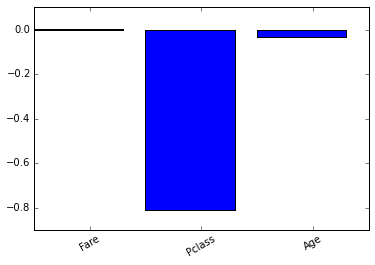

In [60]:
x = np.arange(len(feature_names))
plt.bar(x, logreg.coef_.ravel())
plt.xticks(x + 0.5, feature_names, rotation=30);

In this case, survival is slightly positively linked with Fare (the higher the fare, the higher the likelyhood the model will predict survival) while passenger from first class and lower ages are predicted to survive more often than older people from the 3rd class.

First-class cabins were closer to the lifeboats and children and women reportedly had the priority. Our model seems to capture that historical data. We will see later if the sex of the passenger can be used as an informative predictor to increase the predictive accuracy of the model.

### Alternative evaluation metrics

It is possible to see the details of the false positive and false negative errors by computing the confusion matrix:

In [61]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(target_test, target_predicted)
print(cm)

[[98 12]
 [36 33]]


The true labeling are seen as the rows and the predicted labels are the columns:

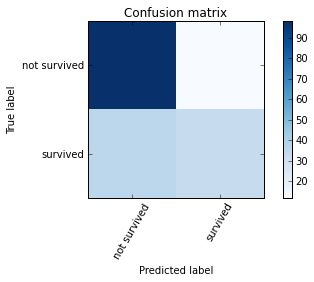

In [62]:
def plot_confusion(cm, target_names = ['not survived', 'survived'],
                   title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Convenience function to adjust plot parameters for a clear layout.
    plt.tight_layout()
    
plot_confusion(cm)

In [63]:
print(cm)

[[98 12]
 [36 33]]


We can normalize the number of prediction by dividing by the total number of true "survived" and "not survived" to compute true and false positive rates for survival in the first row and the false negative and true negative rates in the second row.

In [64]:
cm.sum(axis=1)

array([110,  69])

In [65]:
cm_normalized = cm.astype(np.float64) / cm.sum(axis=1)[:, np.newaxis]
print(cm_normalized)

[[ 0.89090909  0.10909091]
 [ 0.52173913  0.47826087]]


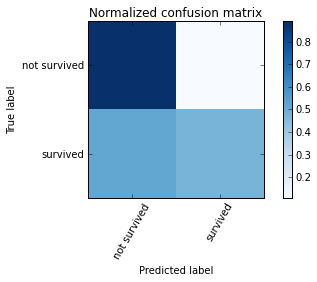

In [66]:
plot_confusion(cm_normalized, title="Normalized confusion matrix")

We can therefore observe that the fact that the target classes are not balanced in the dataset makes the accuracy score not very informative.

scikit-learn provides alternative classification metrics to evaluate models performance on imbalanced data such as precision, recall and f1 score:

In [67]:
from sklearn.metrics import classification_report

print(classification_report(target_test, target_predicted,
                            target_names=['not survived', 'survived']))

              precision    recall  f1-score   support

not survived       0.73      0.89      0.80       110
    survived       0.73      0.48      0.58        69

 avg / total       0.73      0.73      0.72       179



Another way to quantify the quality of a binary classifier on imbalanced data is to compute the precision, recall and f1-score of a model (at the default fixed decision threshold of 0.5).

Logistic Regression is a probabilistic models: instead of just predicting a binary outcome (survived or not) given the input features it can also estimates the posterior probability of the outcome given the input features using the `predict_proba` method:

In [68]:
target_predicted_proba = logreg.predict_proba(features_test)
target_predicted_proba[:5]

array([[ 0.75263264,  0.24736736],
       [ 0.75824771,  0.24175229],
       [ 0.58542437,  0.41457563],
       [ 0.25224882,  0.74775118],
       [ 0.75817844,  0.24182156]])

By default the decision threshold is 0.5: if we vary the decision threshold from 0 to 1 we could generate a family of binary classifier models that address all the possible trade offs between false positive and false negative prediction errors.

We can summarize the performance of a binary classifier for all the possible thresholds by plotting the ROC curve and quantifying the Area under the ROC curve:

In [69]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(target_test, target_predicted_proba):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:, 1])
    
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")

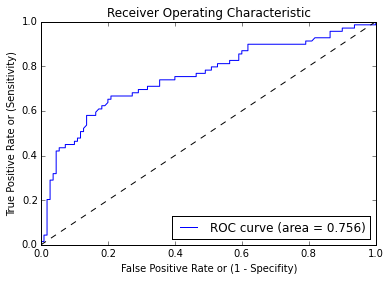

In [70]:
plot_roc_curve(target_test, target_predicted_proba)

Here the area under ROC curve is 0.756 which is very similar to the accuracy (0.732). However the ROC-AUC score of a random model is expected to 0.5 on average while the accuracy score of a random model depends on the class imbalance of the data. ROC-AUC can be seen as a way to callibrate the predictive accuracy of a model against class imbalance.

### Cross-validation

We previously decided to randomly split the data to evaluate the model on 20% of held-out data. However the location randomness of the split might have a significant impact in the estimated accuracy:

In [71]:
features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.20, random_state=0)

logreg.fit(features_train, target_train).score(features_test, target_test)

0.73184357541899436

In [72]:
features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.20, random_state=1)

logreg.fit(features_train, target_train).score(features_test, target_test)

0.67039106145251393

In [73]:
features_train, features_test, target_train, target_test = train_test_split(
    features_array, target, test_size=0.20, random_state=2)

logreg.fit(features_train, target_train).score(features_test, target_test)

0.66480446927374304

So instead of using a single train / test split, we can use a group of them and compute the min, max and mean scores as an estimation of the real test score while not underestimating the variability:

In [75]:
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(logreg, features_array, target, cv=10)
scores

array([ 0.63333333,  0.62222222,  0.70786517,  0.69662921,  0.68539326,
        0.71910112,  0.73033708,  0.75280899,  0.71910112,  0.71590909])

In [76]:
scores.min(), scores.mean(), scores.max()

(0.62222222222222223, 0.69827006015208259, 0.7528089887640449)

`cross_val_score` reports accuracy by default be it can also be used to report other performance metrics such as ROC-AUC or f1-score:

In [78]:
scores = cross_val_score(logreg, features_array, target, cv=10,
                         scoring='roc_auc')
scores.min(), scores.mean(), scores.max()

(0.57428571428571429, 0.72196884814531881, 0.79117647058823526)

**Exercise**:

- Compute cross-validated scores for other classification metrics ('precision', 'recall', 'f1', 'accuracy'...).

- Change the number of cross-validation folds between 3 and 10: what is the impact on the mean score? on the processing time?

Hints:

The list of classification metrics is available in the online documentation:

  http://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values
  
You can use the `%%time` cell magic on the first line of an IPython cell to measure the time of the execution of the cell. 

## More feature engineering and richer models

Let us now try to build richer models by including more features as potential predictors for our model.

Categorical variables such as `data['Embarked']` or `data['Sex']` can be converted as boolean indicators features also known as dummy variables or one-hot-encoded features:

In [79]:
pd.get_dummies(data['Sex'], prefix='Sex').head(5)

,Sex_female,Sex_male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1


In [86]:
print(data.head(1))
print(data[['Sex', 'Embarked']].head(2))

   PassengerId  Survived  Pclass                     Name   Sex  Age  SibSp  \
0            1         0       3  Braund, Mr. Owen Harris  male   22      1   

   Parch     Ticket  Fare Cabin Embarked  
0      0  A/5 21171  7.25   NaN        S  
      Sex Embarked
0    male        S
1  female        C


In [80]:
pd.get_dummies(data.Embarked, prefix='Embarked').head(5)

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [88]:
data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S


We can combine those new numerical features with the previous features using `pandas.concat` along `axis=1`:

In [89]:
rich_features = pd.concat([data[['Fare', 'Pclass', 'Age', 'Parch']],
                           pd.get_dummies(data['Sex'], prefix='Sex'),
                           pd.get_dummies(data['Embarked'], prefix='Embarked')],
                          axis=1)
rich_features.head(5)

,Fare,Pclass,Age,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,3,22,0,0,1,0,0,1
1,71.2833,1,38,0,1,0,1,0,0
2,7.9250,3,26,0,1,0,0,0,1
3,53.1000,1,35,0,1,0,0,0,1
4,8.0500,3,35,0,0,1,0,0,1


By construction the new `Sex_male` feature is redundant with `Sex_female`. Let us drop it:

In [90]:
rich_features_no_male = rich_features.drop('Sex_male', 1)
rich_features_no_male.head(5)

,Fare,Pclass,Age,Parch,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,3,22,0,0,0,0,1
1,71.2833,1,38,0,1,1,0,0
2,7.9250,3,26,0,1,0,0,1
3,53.1000,1,35,0,1,0,0,1
4,8.0500,3,35,0,0,0,0,1


Let us not forget to imput the median age for passengers without age information:

In [91]:
rich_features_final = rich_features_no_male.fillna(rich_features_no_male.dropna().median())
rich_features_final.head(5)

,Fare,Pclass,Age,Parch,Sex_female,Embarked_C,Embarked_Q,Embarked_S
0,7.2500,3,22,0,0,0,0,1
1,71.2833,1,38,0,1,1,0,0
2,7.9250,3,26,0,1,0,0,1
3,53.1000,1,35,0,1,0,0,1
4,8.0500,3,35,0,0,0,0,1


We can finally cross-validate a logistic regression model on this new data an observe that the mean score has significantly increased:

In [93]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score

logreg = LogisticRegression(C=5)
scores = cross_val_score(logreg, rich_features_final, target, cv=10, scoring='accuracy')
print("Logistic Regression CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

Logistic Regression CV scores:
min: 0.767, mean: 0.797, max: 0.854
Wall time: 36 ms


**Exercise**:

- change the value of the parameter `C`. Does it have an impact on the score?

- fit a new instance of the logistic regression model on the full dataset.

- plot the weights for the features of this newly fitted logistic regression model.

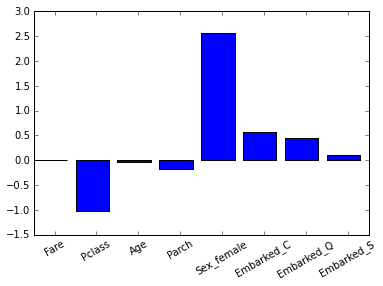

In [95]:
# %load solutions/04A_plot_logistic_regression_weights.py
logreg_new = LogisticRegression(C=1).fit(rich_features_final, target)

feature_names = rich_features_final.columns.values
x = np.arange(len(feature_names))
plt.bar(x, logreg_new.coef_.ravel())
_ = plt.xticks(x + 0.5, feature_names, rotation=30)

# Rich young women like Kate Winslet tend to survive the Titanic better
# than poor men like Leonardo.


### Training Non-linear models: ensembles of randomized trees

`sklearn` also implement non linear models that are known to perform very well for data-science projects where datasets have not too many features (e.g. less than 5000).

In particular let us have a look at Random Forests and Gradient Boosted Trees:

In [96]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, rich_features_final, target, cv=5, n_jobs=4,
                         scoring='accuracy')
print("Random Forest CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

Random Forest CV scores:
min: 0.760, mean: 0.808, max: 0.865
Wall time: 2.99 s


In [99]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,
                                subsample=.8, max_features=.5)
scores = cross_val_score(gb, rich_features_final, target, cv=10, n_jobs=4,
                         scoring='accuracy')
print("Gradient Boosted Trees CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

Gradient Boosted Trees CV scores:
min: 0.753, mean: 0.814, max: 0.876
Wall time: 1.73 s


In [101]:
gb

GradientBoostingClassifier(init=None, learning_rate=0.5, loss='deviance',
              max_depth=3, max_features=0.5, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2, n_estimators=100,
              random_state=None, subsample=0.8, verbose=0,
              warm_start=False)

Both models seem to do slightly better than the logistic regression model on this data.

**Exercise**:

- Change the value of the learning_rate and other `GradientBoostingClassifier` parameter, can you get a better mean score?

- Would treating the `PClass` variable as categorical improve the models performance?

- Find out which predictor variables (features) are the most informative for those models.

Hints:

Fitted ensembles of trees have `feature_importances_` attribute that can be used similarly to the `coef_` attribute of linear models.

In [103]:
# %load solutions/04B_more_categorical_variables.py
features = pd.concat([data.get(['Fare', 'Age']),
                      pd.get_dummies(data.Sex, prefix='Sex'),
                      pd.get_dummies(data.Pclass, prefix='Pclass'),
                      pd.get_dummies(data.Embarked, prefix='Embarked')],
                     axis=1)
features = features.drop('Sex_male', 1)
features = features.fillna(features.dropna().median())
features.head(5)


logreg = LogisticRegression(C=1)
scores = cross_val_score(logreg, features, target, cv=5, scoring='accuracy')
print("Logistic Regression CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))

gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                subsample=.8, max_features=.5)
scores = cross_val_score(gb, features, target, cv=5, n_jobs=4,
                         scoring='accuracy')
print("Gradient Boosting Trees CV scores:")
print("min: {:.3f}, mean: {:.3f}, max: {:.3f}".format(
    scores.min(), scores.mean(), scores.max()))


Logistic Regression CV scores:
min: 0.770, mean: 0.789, max: 0.816
Gradient Boosting Trees CV scores:
min: 0.799, mean: 0.829, max: 0.854


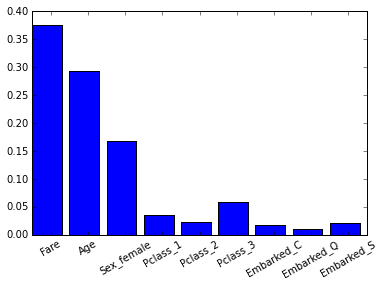

In [105]:
# %load solutions/04C_feature_importance.py
gb_new = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                    subsample=.8, max_features=.5)
gb_new.fit(features, target)
feature_names = features.columns.values
x = np.arange(len(feature_names))
plt.bar(x, gb_new.feature_importances_)
_ = plt.xticks(x + 0.5, feature_names, rotation=30)


## Automated parameter tuning

Instead of changing the value of the learning rate manually and re-running the cross-validation, we can find the best values for the parameters automatically (assuming we are ready to wait):

In [106]:
%%time

from sklearn.grid_search import GridSearchCV

gb = GradientBoostingClassifier(n_estimators=100, subsample=.8)

params = {
    'learning_rate': [0.05, 0.1, 0.5],
    'max_features': [0.5, 1],
    'max_depth': [3, 4, 5],
}
gs = GridSearchCV(gb, params, cv=5, scoring='roc_auc', n_jobs=4)
gs.fit(rich_features_final, target)

Wall time: 6.28 s


In [110]:
GridSearchCV?

Let us sort the models by mean validation score:

In [107]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

[mean: 0.87217, std: 0.03167, params: {'max_depth': 4, 'learning_rate': 0.05, 'max_features': 0.5},
 mean: 0.87081, std: 0.02579, params: {'max_depth': 3, 'learning_rate': 0.1, 'max_features': 0.5},
 mean: 0.87031, std: 0.02365, params: {'max_depth': 3, 'learning_rate': 0.5, 'max_features': 0.5},
 mean: 0.87030, std: 0.02922, params: {'max_depth': 4, 'learning_rate': 0.1, 'max_features': 0.5},
 mean: 0.86877, std: 0.03140, params: {'max_depth': 5, 'learning_rate': 0.05, 'max_features': 0.5},
 mean: 0.86865, std: 0.03426, params: {'max_depth': 4, 'learning_rate': 0.1, 'max_features': 1},
 mean: 0.86799, std: 0.02591, params: {'max_depth': 3, 'learning_rate': 0.05, 'max_features': 0.5},
 mean: 0.86797, std: 0.03147, params: {'max_depth': 5, 'learning_rate': 0.05, 'max_features': 1},
 mean: 0.86763, std: 0.02570, params: {'max_depth': 3, 'learning_rate': 0.1, 'max_features': 1},
 mean: 0.86671, std: 0.02747, params: {'max_depth': 4, 'learning_rate': 0.05, 'max_features': 1},
 mean: 0.8659

In [108]:
gs.best_score_

0.87217453465672057

In [109]:
gs.best_params_

{'learning_rate': 0.05, 'max_depth': 4, 'max_features': 0.5}

We should note that the mean scores are very close to one another and almost always within one standard deviation of one another. This means that all those parameters are quite reasonable. The only parameter of importance seems to be the `learning_rate`: 0.5 seems to be a bit too high.

## Avoiding data snooping with pipelines

When doing imputation in pandas, prior to computing the train test split we use data from the test to improve the accuracy of the median value that we impute on the training set. This is actually cheating. To avoid this we should compute the median of the features on the training fold and use that median value to do the imputation both on the training and validation fold for a given CV split.

To do this we can prepare the features as previously but without the imputation: we just replace missing values by the -1 marker value:

In [ ]:
features = pd.concat([data[['Fare', 'Age']],
                      pd.get_dummies(data['Sex'], prefix='Sex'),
                      pd.get_dummies(data['Pclass'], prefix='Pclass'),
                      pd.get_dummies(data['Embarked'], prefix='Embarked')],
                     axis=1)
features = features.drop('Sex_male', 1)

# Because of the following bug we cannot use NaN as the missing
# value marker, use a negative value as marker instead:
# https://github.com/scikit-learn/scikit-learn/issues/3044
features = features.fillna(-1)
features.head(5)

We can now use the `Imputer` transformer of scikit-learn to find the median value on the training set and apply it on missing values of both the training set and the test set.

In [ ]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features.values, target, random_state=0)

In [ ]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy='median', missing_values=-1)

imputer.fit(X_train)

The median age computed on the training set is stored in the `statistics_` attribute.

In [ ]:
imputer.statistics_

In [ ]:
features.columns.values

Imputation can now happen by calling  the transform method:

In [ ]:
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [ ]:
np.any(X_train == -1)

In [ ]:
np.any(X_train_imputed == -1)

In [ ]:
np.any(X_test == -1)

In [ ]:
np.any(X_test_imputed == -1)

We can now use a pipeline that wraps an imputer transformer and the classifier itself:

In [ ]:
from sklearn.pipeline import Pipeline

imputer = Imputer(strategy='median', missing_values=-1)

classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1,
                                        subsample=.8, max_features=.5,
                                        random_state=0)

pipeline = Pipeline([
    ('imp', imputer),
    ('clf', classifier),
])

scores = cross_val_score(pipeline, features.values, target, cv=5, n_jobs=4,
                         scoring='accuracy', )
print(scores.min(), scores.mean(), scores.max())

The mean cross-validation is slightly lower than we used the imputation on the whole data as we did earlier although not by much. This means that in this case the data-snooping was not really helping the model cheat by much.

Let us re-run the grid search, this time on the pipeline. Note that thanks to the pipeline structure we can optimize the interaction of the imputation method with the parameters of the downstream classifier without cheating:

In [ ]:
%%time

params = {
    'imp__strategy': ['mean', 'median'],
    'clf__max_features': [0.5, 1],
    'clf__max_depth': [3, 4, 5],
}
gs = GridSearchCV(pipeline, params, cv=5, scoring='roc_auc', n_jobs=4)
gs.fit(X_train, y_train)

In [ ]:
sorted(gs.grid_scores_, key=lambda x: x.mean_validation_score, reverse=True)

In [ ]:
gs.best_score_

In [ ]:
plot_roc_curve(y_test, gs.predict_proba(X_test))

In [ ]:
gs.best_params_

From this search we can conclude that the imputation by the 'mean' strategy is generally a slightly better imputation strategy when training a GBRT model on this data.

## Further integrating sklearn and pandas

Helper tool for better sklearn / pandas integration: https://github.com/paulgb/sklearn-pandas by making it possible to embed the feature construction from the raw dataframe directly inside a pipeline.

### Credits

Thanks to:

- Kaggle for setting up the Titanic challenge.

- This blog post by Philippe Adjiman for inspiration:

http://www.philippeadjiman.com/blog/2013/09/12/a-data-science-exploration-from-the-titanic-in-r/